# Chapter 5: Risk management and backtest



### 5.1. The backtesting metrics
> ###### 5.1.1. The CAPM metrics
> ###### 5.1.2.	 Sharpe and Sortino
> ###### 5.1.3. Drawdown


### 5.2. Risk management analysis
> ###### 5.2.1. Value at risk (VaR)
> ###### 5.2.2. Conditional Value at risk (cVaR)
> ###### 5.2.3 Contribution risk



### 5.3. Automate the analysis
> ###### 5.3.1. Create a function
> ###### 5.3.2. Analyze static portfolio
> ###### 5.3.3. Analyze dynamic portfolio




In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
# Importation of data
list_tickers = ["FB", "NFLX", "TSLA"]
database = yf.download(list_tickers)

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna().pct_change(1).dropna()

[*********************100%***********************]  3 of 3 completed


In [3]:
def MV_criterion(weight, data):
    """ 
    -----------------------------------------------------------------------------
    | Output: optimization porfolio criterion                                   |
    -----------------------------------------------------------------------------
    | Inputs: -weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type ndarray numpy): Returns of stocks                     |
    -----------------------------------------------------------------------------
    """

    # Parameters
    Lambda = 3
    W=1
    Wbar=1+0.25/100

    # Compute portfolio returns
    portfolio_return= np.multiply(data,np.transpose(weight))
    portfolio_return= portfolio_return.sum(axis=1)

    # Compute mean and volatility of the portfolio
    mean= np.mean(portfolio_return,axis=0)
    std= np.std(portfolio_return,axis=0)

    # Compute the criterion
    criterion = Wbar**(1-Lambda)/(1+Lambda)+Wbar**(-Lambda)\
    *W*mean-Lambda/2*Wbar**(-1-Lambda)*W**2*std**2
    criterion=-criterion
    return criterion

split = int(0.7*len(data))
train_set = data.iloc[:split,:]
test_set = data.iloc[split:,:]

# Find the number of asset
n=data.shape[1]

# Initialisation weight value
x0 = np.ones(n)

# Optimization constraints problem
cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

# Set the bounds
Bounds= [(0 , 1) for i in range(0,n)]


# Optimization problem solving
res_MV = minimize(MV_criterion, x0, method="SLSQP",
                  args=(train_set),bounds=Bounds,
                  constraints=cons,options={'disp': True})

# Result for computations
X_MV = res_MV.x

# Compute the cumulative return of the portfolio (CM)
portfolio_return_MV = np.multiply(test_set,np.transpose(X_MV))
portfolio_return_MV = portfolio_return_MV.sum(axis=1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.25002463954220266
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2


<br>

### 5.1.1. The CAPM metrics

In [4]:
def beta_function(portfolio, ben = "^GSPC"):
    """ 
    -----------------------------------------------------------------------------
    | Output: Beta CAPM metric                                                  |
    -----------------------------------------------------------------------------
    | Inputs: - portfolio (type dataframe pandas): Returns of the portfolio     |
    |         - ben (type string): Name of the benchmark                        |
    -----------------------------------------------------------------------------
    """

    # Importation of benchmark
    benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

    # Concat the asset and the benchmark
    join = pd.concat((portfolio, benchmark), axis=1).dropna()

    # Covariance between the asset and the benchmark
    cov = np.cov(join, rowvar=False)[0][1]

    # Compute the variance of the benchmark
    var = np.cov(join, rowvar=False)[1][1]

    return cov/var

beta_function(portfolio_return_MV)

[*********************100%***********************]  1 of 1 completed


1.0617413789235222

In [5]:
def alpha_function(portfolio, ben = "^GSPC", timeframe= 252):
    """ 
    -----------------------------------------------------------------------------
    | Output: Aplha CAPM metric                                                 |
    -----------------------------------------------------------------------------
    | Inputs: - portfolio (type dataframe pandas): Returns of the portfolio     |
    |         - ben (type string): Name of the benchmark                        |
    |         - timeframe (type int): annualization factor                      |
    -----------------------------------------------------------------------------
    """

    # Importation of benchmark
    benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

    # Concat the asset and the benchmark
    join = pd.concat((portfolio, benchmark), axis=1).dropna()

    # Compute the beta
    beta = beta_function(portfolio_return_MV, ben=ben)

    mean_stock_return = join.iloc[:,0].mean()*timeframe
    mean_market_return = join.iloc[:,1].mean()*timeframe
    return mean_stock_return - beta*mean_market_return

alpha_function(portfolio_return_MV)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


0.37841040148639893

<br>

### 5.1.2. Sharpe and Sortino

In [6]:
def sharpe_function(portfolio, timeframe= 252):
    """ 
    -----------------------------------------------------------------------------
    | Output: Sharpe ratio metric                                               |
    -----------------------------------------------------------------------------
    | Inputs: - portfolio (type dataframe pandas): Returns of the portfolio     |
    |         - timeframe (type int): annualization factor                      |
    -----------------------------------------------------------------------------
    """

    mean = portfolio.mean() * timeframe
    std = portfolio.std() * np.sqrt(timeframe)

    return mean/std

sharpe_function(portfolio_return_MV)

1.589959530482027

In [7]:
def sortino_function(portfolio, timeframe= 252):
    """ 
    -----------------------------------------------------------------------------
    | Output: Sortino ratio metric                                              |
    -----------------------------------------------------------------------------
    | Inputs: - portfolio (type dataframe pandas): Returns of the portfolio     |
    |         - timeframe (type int): annualization factor                      |
    -----------------------------------------------------------------------------
    """

    # Take downward values
    portfolio = portfolio.values
    downward = portfolio[portfolio<0]


    mean = portfolio.mean() * timeframe
    std = downward.std() * np.sqrt(timeframe)

    return mean/std

sortino_function(portfolio_return_MV)

2.1335426572122307

<br>

### 5.1.3. Drawdown

In [8]:
def drawdown_function(portfolio):
    """ 
    -----------------------------------------------------------------------------
    | Output: Drawdown                                                          |
    -----------------------------------------------------------------------------
    | Inputs: - portfolio (type dataframe pandas): Returns of the portfolio     |
    -----------------------------------------------------------------------------
    """
    # Compute the cumulative product returns
    cum_rets = (portfolio+1).cumprod()

    # Compute the running max
    running_max = np.maximum.accumulate(cum_rets.dropna())
    running_max[running_max < 1] = 1

    # Compute the drawdown
    drawdown = ((cum_rets)/running_max - 1)

    return drawdown

drawdown = drawdown_function(portfolio_return_MV)

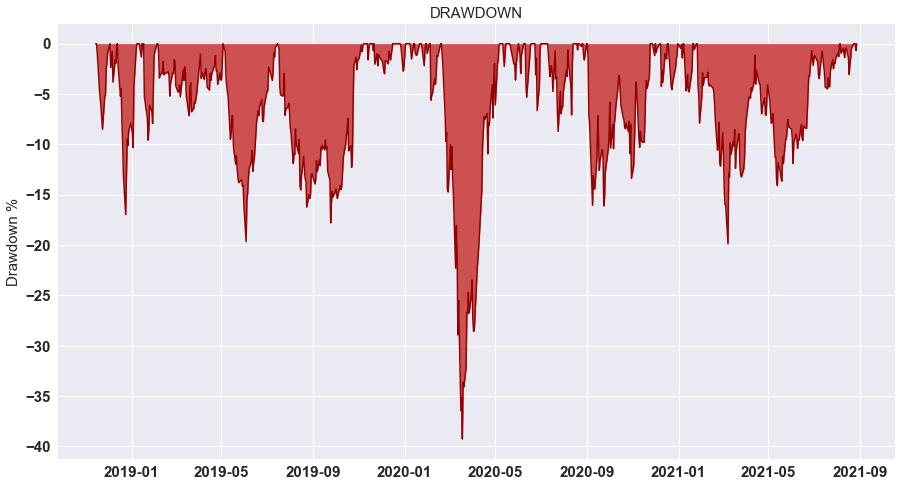

In [12]:
plt.figure(figsize=(15,8))
plt.fill_between(drawdown.index, drawdown*100, 0, color="#CE5151")
plt.plot(drawdown.index,drawdown*100, color="#930303", linewidth=1.5)
plt.title("DRAWDOWN", size=15)
plt.ylabel("Drawdown %", size=15)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.savefig(f'drawdown explication.svg', format='svg', dpi=1200)
plt.show()

<br>

### 5.2.1. Value at Risk (VaR)

In [10]:
def VaR_function(theta, mu, sigma):
    """ 
    -----------------------------------------------------------------------------
    | Output: VaR                                                               |
    -----------------------------------------------------------------------------
    | Inputs: - theta (type float): % error threshold                           |
    |         - mu (type float): portfolio expected return                      |
    |         - sigma (type float): portfolio volatility                        |
    -----------------------------------------------------------------------------
    """
    # Number of simulations
    n = 100000

    # Find the values for theta% error threshold
    t = int(n*theta)

    # Create a vector with n simulations of the normal law
    vec = pd.DataFrame(np.random.normal(mu, sigma, size=(n,)),
                     columns = ["Simulations"])

    # Orderer the values and find the theta% value
    var = vec.sort_values(by="Simulations").iloc[t].values[0]

    return var
print("daily:",VaR_function(0.05, portfolio_return_MV.mean(), portfolio_return_MV.std()))
print("monthly:",VaR_function(0.05, portfolio_return_MV.mean()*20, portfolio_return_MV.std()*np.sqrt(20)))
print("yearly:",VaR_function(0.05, portfolio_return_MV.mean()*252, portfolio_return_MV.std()*np.sqrt(252)))

daily: -0.03720117772219805
monthly: -0.13078473552263706
yearly: -0.04597564252555275


<br>

### 5.2.2. Conditional Value at Risk (cVaR)

In [11]:
def cVaR_function(theta, mu, sigma):
    """ 
    -----------------------------------------------------------------------------
    | Output: cVaR                                                              |
    -----------------------------------------------------------------------------
    | Inputs: - theta (type float): % error threshold                           |
    |         - mu (type float): portfolio expected return                      |
    |         - sigma (type float): portfolio volatility                        |
    -----------------------------------------------------------------------------
    """
    # Number of simulations
    n = 100000

    # Find the values for theta% error threshold
    t = int(n*theta)

    # Create a vector with n simulations of the normal law
    vec = pd.DataFrame(np.random.normal(mu, sigma, size=(n,)),
                     columns = ["Simulations"])

    # Orderer the values and find the theta% value
    cvar = vec.sort_values(by="Simulations").iloc[0:t,:].mean().values[0]

    return cvar

print("daily:",cVaR_function(0.05, portfolio_return_MV.mean(), portfolio_return_MV.std()))
print("monthly:",cVaR_function(0.05, portfolio_return_MV.mean()*20, portfolio_return_MV.std()*np.sqrt(20)))
print("yearly:",cVaR_function(0.05, portfolio_return_MV.mean()*252, portfolio_return_MV.std()*np.sqrt(252)))

daily: -0.0466619318746246
monthly: -0.17584258945174333
yearly: -0.21217564369641267


<br>

### 5.2.3. Contribution risk

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


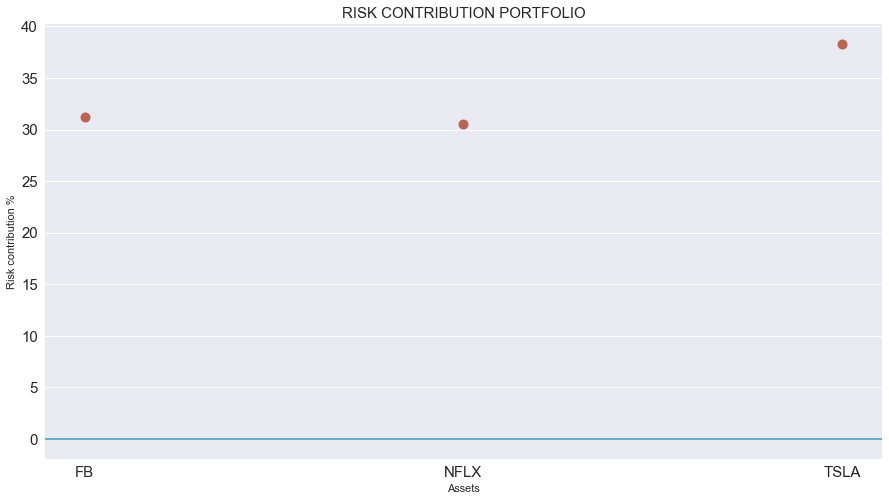

In [13]:
def CR_function(weights,database, ben="^GSPC"):
    """ 
    ----------------------------------------------------------------------------
    | Output: Contribution risk                                                |
    ----------------------------------------------------------------------------
    | Inputs: - weights (type 1d array numpy): weights of the portfolio        |
    |         - database (type dataframe pandas): Returns of the asset         |
    |         - ben (type string): Name of the benchmark                       |
    ----------------------------------------------------------------------------
    """
    # Find the number of the asset in the portfolio
    l = len(weights)

    # Compute the risk contribution of each asset
    crs = []
    for i in range(l):
        cr = beta_function(data.iloc[:,i]) * weights[i]
        crs.append(cr)

    return crs/np.sum(crs) # Normalizing by the sum of the risk contribution


CR = CR_function(X_MV,data, ben="^GSPC")

plt.figure(figsize=(15,8))
plt.scatter(list_tickers, CR*100, linewidth=3, color = "#B96553")
plt.axhline(0, color="#53A7B9")
plt.grid(axis="x")
plt.title("RISK CONTRIBUTION PORTFOLIO", size=15)
plt.xlabel("Assets")
plt.ylabel("Risk contribution %")
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

<br>

### 5.3.1. Create a function

In [16]:
def backtest_static_portfolio(weights, database, ben="^GSPC", timeframe=252, CR=False):
    """
    -----------------------------------------------------------------------------
    | Output: Backtest static portfolio                                         |
    -----------------------------------------------------------------------------
    | Inputs: - weights (type 1d array numpy): weights of the portfolio         |
    |         - database (type dataframe pandas): Returns of the asset          |
    |         - ben (type string): Name of the benchmark                        |
    |         - timeframe (type int): annualization factor                      |
    -----------------------------------------------------------------------------
    """
    import pandas as pd
    import yfinance as yf
    import numpy as np
    from scipy.optimize import minimize
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')


    # Compute the portfolio
    portfolio = np.multiply(database,np.transpose(weights))
    portfolio = portfolio.sum(axis=1)
    columns = database.columns
    columns = [col for col in columns]

    ######################### COMPUTE THE BETA ##################################
    # Importation of benchmark
    benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

    # Concat the asset and the benchmark
    join = pd.concat((portfolio, benchmark), axis=1).dropna()

    # Covariance between the asset and the benchmark
    cov = np.cov(join, rowvar=False)[0][1]

    # Compute the variance of the benchmark
    var = np.cov(join, rowvar=False)[1][1]

    beta = cov/var


    ######################### COMPUTE THE ALPHA #################################
    # Mean of returns for the asset
    mean_stock_return = join.iloc[:,0].mean()*timeframe

    # Mean of returns for the market
    mean_market_return = join.iloc[:,1].mean()*timeframe

    # Alpha
    alpha = mean_stock_return - beta*mean_market_return


    ######################### COMPUTE THE SHARPE ################################
    mean = portfolio.mean() * timeframe
    std = portfolio.std() * np.sqrt(timeframe)
    Sharpe = mean/std


    ######################### COMPUTE THE SORTINO ###############################
    downward = portfolio[portfolio<0]
    std_downward = downward.std() * np.sqrt(timeframe)
    Sortino = mean/std_downward


    ######################### COMPUTE THE DRAWDOWN ###############################
    # Compute the cumulative product returns
    cum_rets = (portfolio+1).cumprod()

    # Compute the running max
    running_max = np.maximum.accumulate(cum_rets.dropna())
    running_max[running_max < 1] = 1

    # Compute the drawdown
    drawdown = ((cum_rets)/running_max - 1)
    min_drawdon = -drawdown.min()


    ######################### COMPUTE THE VaR ##################################
    theta = 0.01
    # Number of simulations
    n = 100000

    # Find the values for theta% error threshold
    t = int(n*theta)

    # Create a vector with n simulations of the normal law
    vec = pd.DataFrame(np.random.normal(mean, std, size=(n,)),
                      columns = ["Simulations"])

    # Orderer the values and find the theta% value
    VaR = -vec.sort_values(by="Simulations").iloc[t].values[0]


    ######################### COMPUTE THE cVaR #################################
    cVaR = -vec.sort_values(by="Simulations").iloc[0:t,:].mean().values[0]

    ######################### COMPUTE THE RC ###################################
    if CR:
    # Find the number of the asset in the portfolio
        l = len(weights)

        # Compute the risk contribution of each asset
        crs = []
        for i in range(l):
            # Importation of benchmark
            benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

            # Concat the asset and the benchmark
            join = pd.concat((database.iloc[:,i], benchmark), axis=1).dropna()

            # Covariance between the asset and the benchmark
            cov = np.cov(join, rowvar=False)[0][1]

            # Compute the variance of the benchmark
            var = np.cov(join, rowvar=False)[1][1]

            beta_s = cov/var
            cr = beta_s * weights[i]
            crs.append(cr)

        crs = crs/np.sum(crs) # Normalizing by the sum of the risk contribution

    ######################### PLOT THE RESULTS #################################
    print(f"""
    -----------------------------------------------------------------------------
    Portfolio: {columns}
    -----------------------------------------------------------------------------
    Beta: {np.round(beta, 3)} \t Alpha: {np.round(alpha*100, 2)} %\t \
    Sharpe: {np.round(Sharpe, 3)} \t Sortino: {np.round(Sortino, 3)}
    -----------------------------------------------------------------------------
    VaR: {np.round(VaR*100, 2)} %\t cVaR: {np.round(cVaR*100, 2)} % \t \
    VaR/cVaR: {np.round(cVaR/VaR, 3)} \t drawdown: {np.round(min_drawdon*100, 2)} %
    -----------------------------------------------------------------------------
    """)


    plt.figure(figsize=(15,8))
    plt.plot(join.iloc[:,0].cumsum()*100, color="#035593", linewidth=3)
    plt.plot(join.iloc[:,1].cumsum()*100, color="#068C72", linewidth=3)
    plt.title("CUMULTATIVE RETURN", size=15)
    plt.ylabel("Cumulative return %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    plt.legend(["Strategy", "Benchmark"])
    plt.savefig(f'Cum.svg', format='svg', dpi=1200)
    plt.show()

    plt.figure(figsize=(15,8))
    plt.fill_between(drawdown.index, drawdown*100, 0, color="#CE5151")
    plt.plot(drawdown.index,drawdown*100, color="#930303", linewidth=1.5)
    plt.title("DRAWDOWN", size=15)
    plt.ylabel("Drawdown %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    plt.savefig(f'drawdown.svg', format='svg', dpi=1200)
    plt.show()



    if CR:
        plt.figure(figsize=(15,8))
        plt.scatter(columns, crs, linewidth=3, color = "#B96553")
        plt.axhline(0, color="#53A7B9")
        plt.grid(axis="x")
        plt.title("RISK CONTRIBUTION PORTFOLIO", size=15)
        plt.xlabel("Assets")
        plt.ylabel("Risk contribution")
        plt.xticks(size=15,fontweight="bold")
        plt.yticks(size=15,fontweight="bold")
        plt.savefig(f'CR.svg', format='svg', dpi=1200)
        plt.show()
        plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['FB', 'NFLX', 'TSLA']
    -----------------------------------------------------------------------------
    Beta: 1.062 	 Alpha: 37.84 %	     Sharpe: 1.59 	 Sortino: 2.13
    -----------------------------------------------------------------------------
    VaR: 27.67 %	 cVaR: 40.14 % 	     VaR/cVaR: 1.451 	 drawdown: 39.27 %
    -----------------------------------------------------------------------------
    


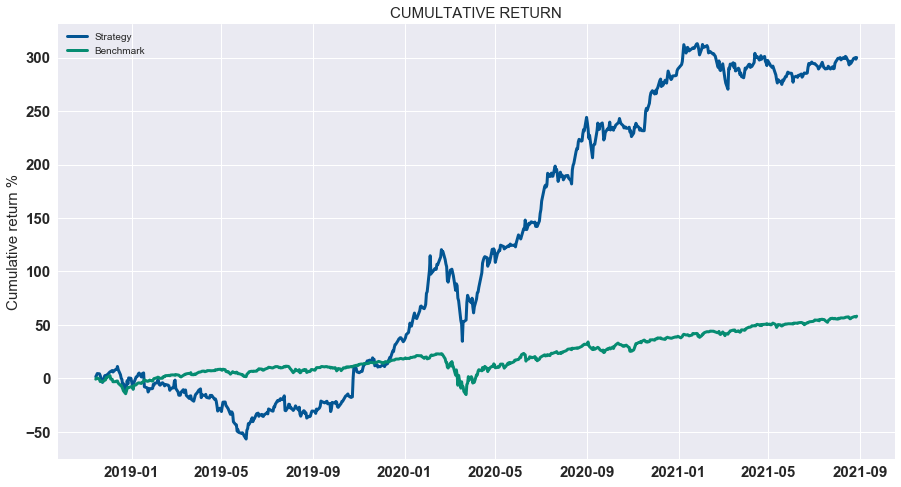

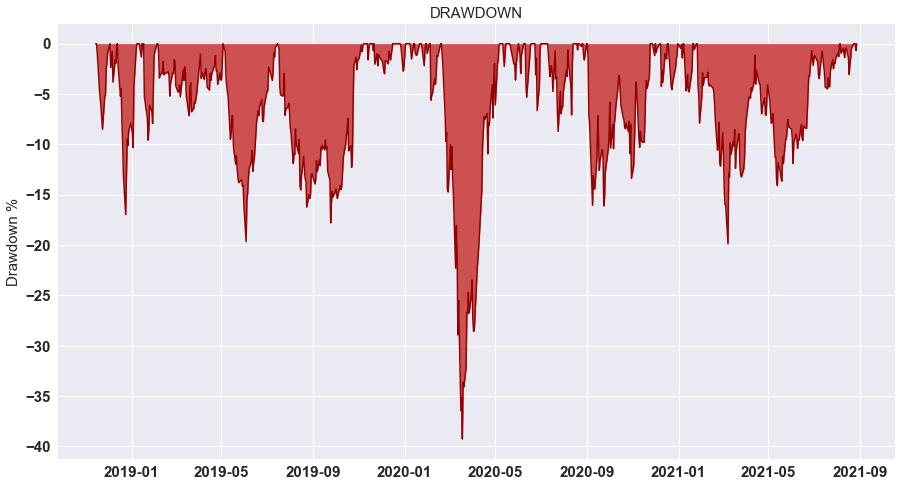

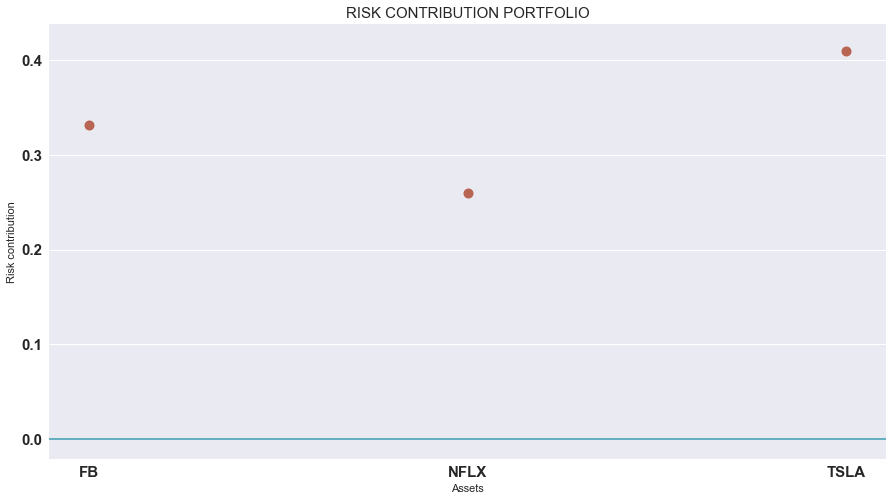

In [17]:
backtest_static_portfolio(X_MV, test_set, ben="^GSPC", timeframe=252, CR=True)